In [1]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import joblib
import tensorflow as tf

<h1>1. Load train data

In [45]:
train1 = pd.read_csv('MELD/train_sent_emo.csv')
train1.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [46]:
train1.shape

(9989, 11)

In [47]:
#Number of unique dialogues
train1['Dialogue_ID'].nunique()

1038

In [48]:
train1['Dialogue_ID'].max()

1038

In [49]:
train2 = pd.read_csv('MELD/dev_sent_emo.csv')
train2.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


In [50]:
train2.shape

(1109, 11)

In [51]:
#Number of unique dialogues
train2['Dialogue_ID'].nunique()

114

In [52]:
train2['Dialogue_ID'] = train2['Dialogue_ID'] + train1['Dialogue_ID'].max() + 1

In [53]:
train = pd.concat([train1,train2],ignore_index=True)
train.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [54]:
train.shape

(11098, 11)

Text(0.5,1,'Bar Graph of Different Emotion Counts')

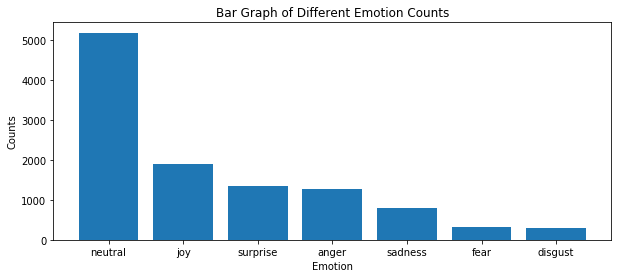

In [55]:
a = train['Emotion'].value_counts()
plt.figure(figsize=(10,4))
plt.bar(a.index,a.values)
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.title('Bar Graph of Different Emotion Counts')

Dataset is imbalanced. Majority of labels belong to neutral class

In [14]:
label_index = {j:i+1 for i,j in enumerate(a.index)}
label_index

{'neutral': 1,
 'joy': 2,
 'surprise': 3,
 'anger': 4,
 'sadness': 5,
 'fear': 6,
 'disgust': 7}

<h1>2. Preprocessing Utterances

In [15]:
for i in train['Utterance'].sample(10,random_state=20):
    print(i)
    print(i.split())
    print(120*'-')

Wow, Monica, you look just like your grandmother. How old was she there?
['Wow,', 'Monica,', 'you', 'look', 'just', 'like', 'your', 'grandmother.', 'How', 'old', 'was', 'she', 'there?']
------------------------------------------------------------------------------------------------------------------------
Yeah, and yknow what? I dont give a tiny rats ass.
['Yeah,', 'and', 'y\x92know', 'what?', 'I', 'don\x92t', 'give', 'a', 'tiny', 'rat\x92s', 'ass.']
------------------------------------------------------------------------------------------------------------------------
And its all because of you, wonderful, amazing you.
['And', 'it\x92s', 'all', 'because', 'of', 'you,', 'wonderful,', 'amazing', 'you.']
------------------------------------------------------------------------------------------------------------------------
You tell her Jack, I cant do it.
['You', 'tell', 'her', 'Jack,', 'I', 'can\x92t', 'do', 'it.']
-------------------------------------------------------------------

In [16]:
#Decontraction of text
def decontracted(phrase):
    """
    Returns decontracted phrases
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
def preprocess(sentence):
    
    # process sentence
    sentence = re.sub('\x92','\'',sentence)
    # decontract sentence
    sentence = decontracted(sentence)
    # creating a space between a word and the punctuation following it
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    # remove extra spaces
    sentence = sentence.strip()
    # make lower case
    sentence = sentence.lower()
    return sentence

In [18]:
tqdm.pandas()
train['Utterance'] = train['Utterance'].progress_apply(lambda x: preprocess(x))

100%|█████████████████████████████████████████████████████████████████████████| 11098/11098 [00:00<00:00, 13114.50it/s]


In [19]:
for i in train['Utterance'].sample(10,random_state=20):
    print(i)
    print(i.split())
    print(120*'-')

wow , monica , you look just like your grandmother . how old was she there ?
['wow', ',', 'monica', ',', 'you', 'look', 'just', 'like', 'your', 'grandmother', '.', 'how', 'old', 'was', 'she', 'there', '?']
------------------------------------------------------------------------------------------------------------------------
yeah , and y know what ? i do not give a tiny rat is ass .
['yeah', ',', 'and', 'y', 'know', 'what', '?', 'i', 'do', 'not', 'give', 'a', 'tiny', 'rat', 'is', 'ass', '.']
------------------------------------------------------------------------------------------------------------------------
and it is all because of you , wonderful , amazing you .
['and', 'it', 'is', 'all', 'because', 'of', 'you', ',', 'wonderful', ',', 'amazing', 'you', '.']
------------------------------------------------------------------------------------------------------------------------
you tell her jack , i can not do it .
['you', 'tell', 'her', 'jack', ',', 'i', 'can', 'not', 'do', 'it', '.

In [20]:
#Number of words in each utterances
utterance_length = train['Utterance'].apply(lambda x:len(x.split())).values

Text(0.5,1,'Histogram of number of words in Utterance')

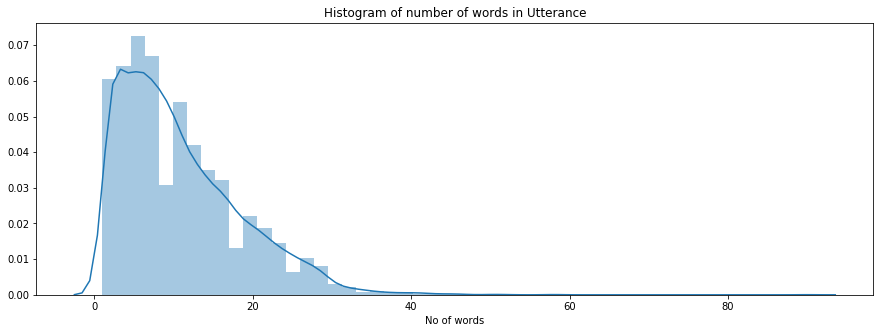

In [21]:
plt.figure(figsize=(15,5))
sns.distplot(utterance_length)
plt.xlabel('No of words')
plt.title('Histogram of number of words in Utterance')

Most of the utterances have fewer than 35 words.

<h1>3. Combine utterances for each dialogue

In [22]:
#Number of unique dialogues
train['Dialogue_ID'].nunique()

1152

In [23]:
train_dict = {}
for i in tqdm(train.groupby('Dialogue_ID')):
    train_dict[i[0]] = i[1][['Utterance','Emotion']].values

100%|█████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:01<00:00, 685.22it/s]


In [24]:
utterances_per_dia = []
for i in train_dict.values():
    utterances_per_dia.append(i.shape[0])

In [25]:
#Maximum utterances for dialogue
max(utterances_per_dia)

24

Text(0.5,1,'Histogram of number of Utterances per dialogue')

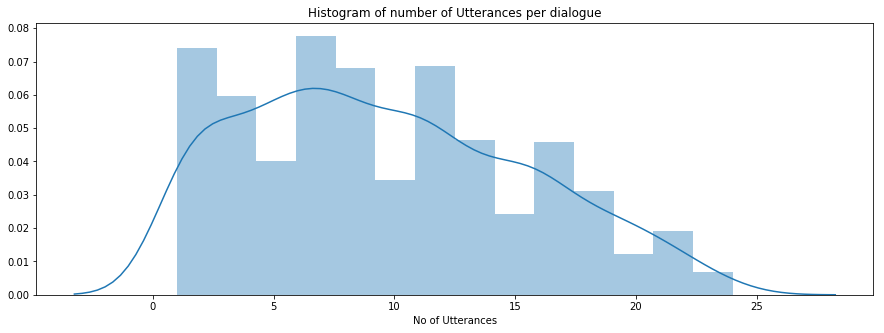

In [26]:
plt.figure(figsize=(15,5))
sns.distplot(utterances_per_dia)
plt.xlabel('No of Utterances')
plt.title('Histogram of number of Utterances per dialogue')

In [27]:
#Drop dialogues whose utterances have more than x words
def drop_dialogue(data_dict,words):
    dig_remove = []
    for i in data_dict.keys():
        for j in data_dict[i]:
            if len(j[0].split())>words:
                dig_remove.append(i)
                break
    return dig_remove

Most of the utterances have fewer than 35 words. Hence dialogues which have utterances more than 35 words are dropped.

In [28]:
#Drop dialogues whose utterances have more than 35 words
train_remove = drop_dialogue(train_dict,35)
len(train_remove)

59

In [29]:
train_dict = {i:j for i,j in train_dict.items() if i not in train_remove}

In [30]:
len(train_dict)

1093

<h1>4. Data Featurization

<h2>4.1. Find unique words in Utterance feature and assign ids

In [31]:
#Get all utterances in train data
utterances = []
for i in tqdm(train_dict.keys()):
    for j in train_dict[i]:
        utterances.append(j[0])
utterances = pd.DataFrame(data={'Utterance':utterances})

100%|███████████████████████████████████████████████████████████████████████████| 1093/1093 [00:00<00:00, 68328.65it/s]


In [32]:
utterances.head()

,Utterance
0,also i was the point person on my company is t...
1,you must have had your hands full .
2,that i did . that i did .
3,so let is talk a little bit about your duties .
4,my duties ? all right .


In [33]:
utterances.shape

(10320, 1)

<h2>4.2. Data Tokenization

In [34]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='<unk>')
tokenizer.fit_on_texts(utterances.Utterance)

In [35]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

5243

In [36]:
#Tokenize one sentence/utterance
def tokenizer_sentence(sentence,pad):
    #Convert text to sequence of integers
    encoded_docs = tokenizer.texts_to_sequences([sentence])
    #Add zero padding at the end
    padded_docs = tf.keras.preprocessing.sequence.pad_sequences(encoded_docs,maxlen=pad,padding='post')
    return padded_docs

In [37]:
#Maximum words in any utterance
max_sentence_length = 35
#Maximum utterances in a dialogue
max_utterances = 24

In [38]:
#Tokenize single dialogue
def tokenize_dialogue(dialogue,max_sentence_length,max_utterances):
    utt = []
    lab = []
    for i in dialogue:
        utt.append(tokenizer_sentence(i[0],pad=max_sentence_length))
        lab.append(label_index[i[1]])
    p = np.array(utt).reshape(-1,max_sentence_length)
    # Pad utterances
    q = np.zeros((max_utterances-len(lab),max_sentence_length),dtype='int8')
    dia_array = np.concatenate([p,q])
    # Padded labels have value 0
    label_array = np.array(lab + [0]*(max_utterances-len(lab)))
    return dia_array,label_array

In [39]:
#Tokenize train data
X_train = []
y_train = []
for i in tqdm(train_dict.keys()):
    p, q = tokenize_dialogue(train_dict[i],max_sentence_length,max_utterances)
    X_train.append(p)
    y_train.append(q)
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|████████████████████████████████████████████████████████████████████████████| 1093/1093 [00:00<00:00, 1191.50it/s]


In [39]:
print(X_train.shape)
print(y_train.shape)

(1093, 24, 35)
(1093, 24)


In [40]:
#Load embedding vectors
#https://nlp.stanford.edu/projects/glove/
embeddings_dict = {}
with open("glove.6B.300d.txt", encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

400000it [01:48, 3678.87it/s]


In [41]:
#create a weight matrix for embedding layer
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████████████████████████████████████████████████████████████████████| 5242/5242 [00:00<00:00, 109224.93it/s]


<h1>5. Test Data Preparation

<h2>5.1. Load test data

In [3]:
test = pd.read_csv('MELD/test_sent_emo.csv')
test.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [4]:
test.shape

(2610, 11)

<h2>5.2. Preprocess data

In [44]:
tqdm.pandas()
test['Utterance'] = test['Utterance'].progress_apply(lambda x: preprocess(x))

100%|████████████████████████████████████████████████████████████████████████████| 2610/2610 [00:00<00:00, 9588.99it/s]


<h2>5.3. Combine utterances for each dialogue

In [45]:
test_dict = {}
for i in tqdm(test.groupby('Dialogue_ID')):
    test_dict[i[0]] = i[1][['Utterance','Emotion']].values

100%|███████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 603.54it/s]


In [46]:
#Drop dialogues whose utterances have more than 35 words
test_remove = drop_dialogue(test_dict,35)
len(test_remove)

13

In [47]:
test_dict = {i:j for i,j in test_dict.items() if i not in test_remove}
len(test_dict)

267

<h2>5.4. Tokenize data

In [48]:
X_test = []
y_test = []
for i in tqdm(test_dict.keys()):
    p, q = tokenize_dialogue(test_dict[i],max_sentence_length,max_utterances)
    X_test.append(p)
    y_test.append(q)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 952.82it/s]


In [49]:
print(X_test.shape)
print(y_test.shape)

(267, 24, 35)
(267, 24)


In [50]:
X_test.shape[0]

267

<h2>5.5. Using 50% of test data for validation

In [51]:
#Generate indices for validate(50%) and test data(50%)
#Validation data
random.seed(42)
val_index = random.sample(range(0,X_test.shape[0]),int(0.5*X_test.shape[0]))
test_index = [i for i in np.arange(X_test.shape[0]) if i not in val_index]

In [52]:
X_val = X_test[val_index]
y_val = y_test[val_index]

In [53]:
print(X_val.shape)
print(y_val.shape)

(133, 24, 35)
(133, 24)


In [54]:
X_test = X_test[test_index]
y_test = y_test[test_index]

In [55]:
print(X_test.shape)
print(y_test.shape)

(134, 24, 35)
(134, 24)


In [56]:
joblib.dump([X_train,y_train,X_val,y_val,X_test,y_test,embedding_matrix,tokenizer,label_index],'utils',compress=6)

['utils']